In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from scipy import stats as st
from scipy. stats import boxcox

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/katarina74/ml_lessons/main/lesson_2/data/techparams_train.csv")

<div class="alert alert-block alert-success">
Данные: технические характеристики разных конфигураций автомобилей

Таргет: длина колесной базы конфигурации (в миллиметрах).

Задача: добиться наименьшего MSE на test.

In [4]:
df.info() #посмотрим общую информацию по датасету

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43245 entries, 0 to 43244
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           43245 non-null  int64  
 1   back-suspension                 43245 non-null  int64  
 2   battery-capacity                43245 non-null  float64
 3   charge-time                     43245 non-null  int64  
 4   compression                     43245 non-null  float64
 5   consumption-mixed               43245 non-null  float64
 6   cylinders-order                 43245 non-null  int64  
 7   cylinders-value                 43245 non-null  int64  
 8   engine-feeding                  43245 non-null  int64  
 9   engine-start                    43245 non-null  int64  
 10  engine-stop                     43245 non-null  int64  
 11  engine-type                     43245 non-null  int64  
 12  gear-type                       

In [5]:
df.duplicated().sum()

0

Дубликатов нет, пропусков тоже.

In [6]:
df['battery-capacity'].unique()

array([ -1.  ,  13.2 ,  21.  ,   1.56,  41.  ,  10.7 ,   1.3 ,  23.  ,
         6.5 ,  90.  ,  18.4 , 100.  ,  14.1 ,   9.2 , 130.  ,  24.  ,
        75.  ,  13.5 ,   1.4 ,  17.6 ,  12.  ,  21.3 ,  31.3 ,  58.  ,
        78.  ,  60.  ,  22.  ,  18.8 ,  40.  ,   4.4 ,  30.  ,  45.  ,
         8.7 , 120.  ,  62.  ,  50.  ,  10.4 ,   1.1 ,  27.2 , 200.  ,
        33.  ,   6.8 ,  93.4 ,   1.31,  64.  ,  32.6 ,   9.27,  11.6 ,
         7.6 ,   5.5 ,  14.4 ,  16.  ,  79.2 ,  41.4 ,  31.2 ,  28.  ,
         1.5 ,  13.  ,  77.  ,  17.1 ,   7.9 ,  42.2 ,  47.17,  95.  ,
        37.  ,  16.5 ,  25.5 ,  17.  ,  11.2 ,  10.8 ,  10.5 ,  70.  ,
        39.2 ,   7.7 ,  71.  ])

target                            1.000000
cylinders-value                   0.472177
configurations_tank-volume        0.413853
cylinders-order                   0.376272
weight                            0.339835
configurations_seats              0.298625
configurations_front-brake        0.184791
engine-start                      0.150944
models_country-from               0.148848
consumption-mixed                 0.118195
max-speed                         0.111922
charge-time                       0.110034
configurations_auto-premiere      0.106856
models_light-and-commercial       0.102416
luxury                            0.085707
gear-type                         0.068319
configurations_back-wheel-base    0.051349
supply-system                     0.045416
power-electro-kw                  0.028609
battery-capacity                  0.025703
compression                       0.023138
valvetrain                        0.021120
engine-feeding                    0.012235
models_male

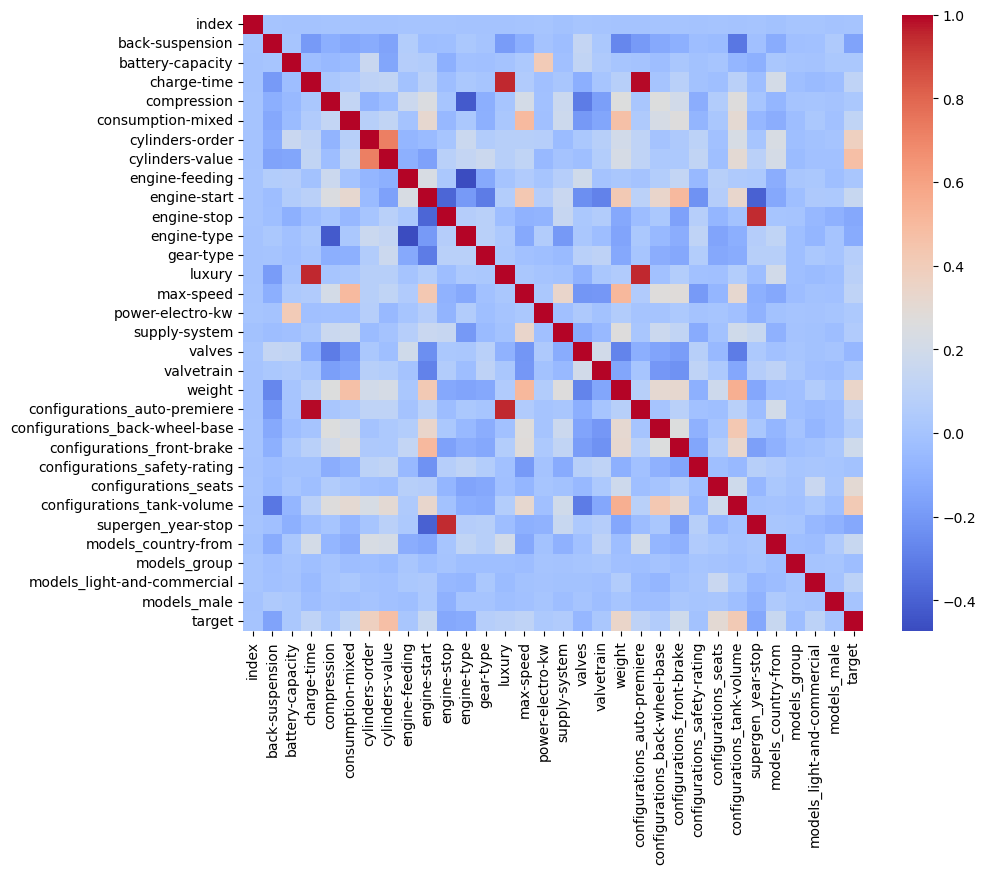

In [7]:
#построим матрицу корреляций для выявление тесноты связи результирующего показателя и фактора
corr_matrix = df.corr()
corr = corr_matrix['target'].sort_values(ascending=False)

print(corr)

#визуализация корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

Видим, что корреляция с целевым признаком очень слабая практически везде, наибольшая связь наблюдается с тремя показателями: cylinders-value                   (0.47),
configurations_tank-volume        (0.41),
cylinders-order                   (0.38).

In [8]:
#проведем категоризацию по переменной weight с целью усиления связи между ней и целевой переменной target
bins = [0, 1000, 1500, 2000, 3000, np.inf]
labels = ['<1000', '1000-1500', '1500-2000', '2000-3000', '>3000']
df['weight_category'] = pd.cut(df['weight'], bins=bins, labels=labels)
df['weight_category_numeric'] = df['weight_category'].astype('category').cat.codes

#проверка категоризации
print(df[['weight', 'weight_category']].head())

   weight weight_category
0   820.0           <1000
1  2350.0       2000-3000
2  1350.0       1000-1500
3  1090.0       1000-1500
4  1410.0       1000-1500


In [9]:
#видно, что корреляция между показателями weight и target увеличились при разбиении на интервалы веса (смотрим на weight_category_numeric)

corr_matrix = df.corr()
corr = corr_matrix['target']
print(corr)

C:\Users\perea\AppData\Local\Temp\ipykernel_2768\4245852500.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


index                             0.002701
back-suspension                  -0.159912
battery-capacity                  0.025703
charge-time                       0.110034
compression                       0.023138
consumption-mixed                 0.118195
cylinders-order                   0.376272
cylinders-value                   0.472177
engine-feeding                    0.012235
engine-start                      0.150944
engine-stop                      -0.137719
engine-type                      -0.125304
gear-type                         0.068319
luxury                            0.085707
max-speed                         0.111922
power-electro-kw                  0.028609
supply-system                     0.045416
valves                           -0.066402
valvetrain                        0.021120
weight                            0.339835
configurations_auto-premiere      0.106856
configurations_back-wheel-base    0.051349
configurations_front-brake        0.184791
configurati

C:\Users\perea\AppData\Local\Temp\ipykernel_2768\1721360731.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['target'], hist= False, kde= True)


<Axes: xlabel='target', ylabel='Density'>

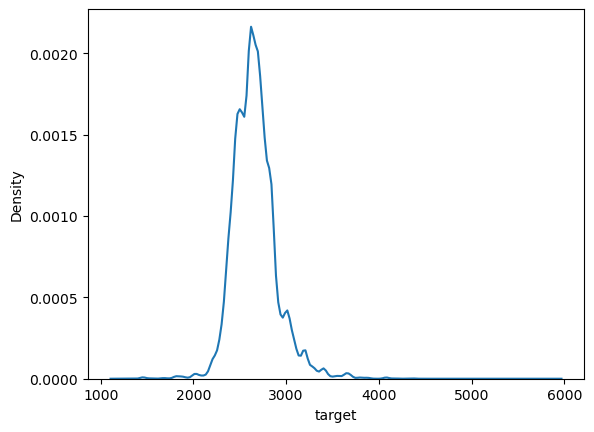

In [10]:
#посмотрим распределение target

sns.distplot(df['target'], hist= False, kde= True)

In [11]:
#проводим тест Шапиро-Уилка для рассмотренного распределения
stat, p = st.shapiro(df['target'])

alpha = 0.05
if p < alpha:
    print(p, 'Отвергаем нулевую гипотезу. Выборка НЕ имеет нормального распределения')
else:
    print(p, 'Не получилось отвергнуть нулевую гипотезу. Выборка имеет нормальное распределение')

0.0 Отвергаем нулевую гипотезу. Выборка НЕ имеет нормального распределения


C:\ProgramData\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


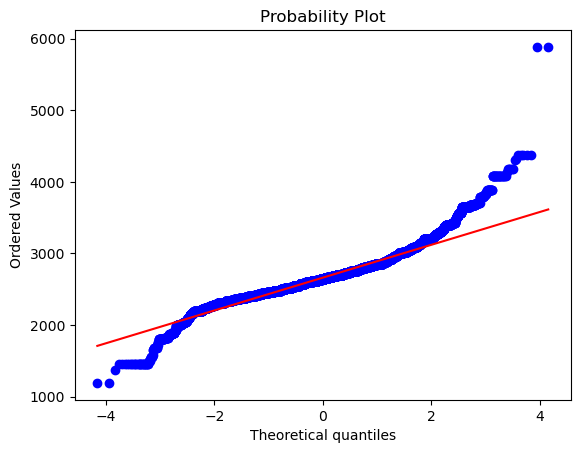

In [12]:
st.probplot(df['target'], dist='norm', plot=plt)
plt.show()

<div class="alert alert-block alert-warning">Видно, что распределение не является нормальным преимущественно из-за хвостов. Поэтому поработаем над выбросами.

[Text(0, 0.5, 'target')]

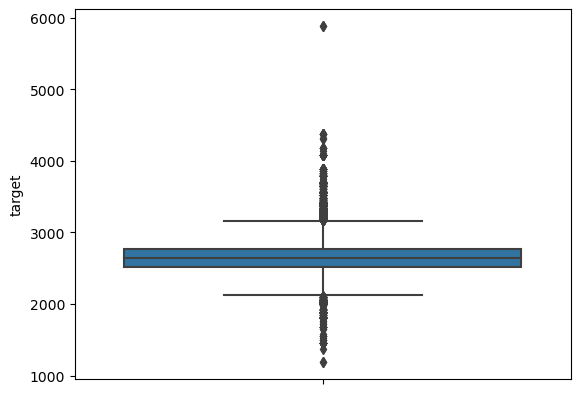

In [13]:
sns.boxplot(data=df, y='target').set(ylabel='target')

In [14]:
#найдем значения экстремальных выбросов в границах 75 и 25 перцентилей
def ejection(col):
    q75 = np.percentile(df[col], 75)
    q25 = np.percentile(df[col], 25)
    iqr = q75 - q25
    ejection_h = q75 + iqr * 1.5
    ejection_l = q25 - iqr * 1.5
    ejection_count = df[col][(df[col] > ejection_h) | (df[col] < ejection_l)].count()
    ejection_perc = ejection_count/df[col].count() * 100
    return(ejection_h, ejection_l, ejection_count, ejection_perc)

In [15]:
ejection('target')

(3170.0, 2114.0, 1694, 3.917215863105562)

In [16]:
#выше мы нашли число и процент выбросов, перезапишем значения в новый датасет без выбросов
data = df[(df['target'] <= ejection('target')[0])&(df['target'] >= ejection('target')[1])]
data = data.reset_index(drop=True)
data.head(3)

,index,back-suspension,battery-capacity,charge-time,compression,consumption-mixed,cylinders-order,cylinders-value,engine-feeding,engine-start,...,configurations_seats,configurations_tank-volume,supergen_year-stop,models_country-from,models_group,models_light-and-commercial,models_male,target,weight_category,weight_category_numeric
0,0,9,-1.0,36457,9.0,4.3,0,3,4,2006,...,13,40.0,2018.0,16,3,0,1,2360,<1000,0
1,2,3,-1.0,44872,8.0,-1.0,3,7,4,1982,...,13,108.0,1993.0,34,3,0,1,3060,2000-3000,3
2,4,3,-1.0,55927,16.0,4.2,0,4,5,2014,...,13,55.0,2019.0,35,3,0,1,2648,1000-1500,1


C:\Users\perea\AppData\Local\Temp\ipykernel_2768\1227042204.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['target'], hist= False, kde= True)


<Axes: xlabel='target', ylabel='Density'>

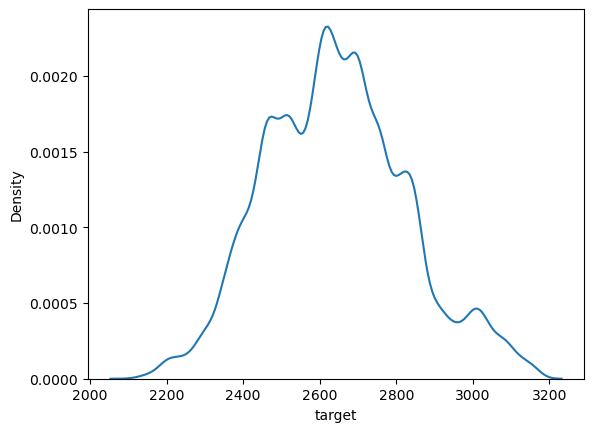

In [17]:
#посмотрим на полученное распределение плотности
sns.distplot(data['target'], hist= False, kde= True)

In [18]:
#тут сначала были использованы преобразования, но затем было принято решение построить модель без них
#transformed_data = np.log1p(data['target'])
#sns.distplot(transformed_data, hist=False, kde=True)
#transformed_data, best_lambda = boxcox(data['target'])
#sns.distplot(transformed_data, hist=False , kde=True)

#data['target'] = transformed_data

In [21]:
ejection('weight')

#удаляем выбросы, с целью избавления от пропусков в weight_category, которые были получены из-за аномальных значений weight
data = data[(data['weight'] <= ejection('weight')[0])&(data['weight'] >= ejection('weight')[1])]
data = data.reset_index(drop=True)

In [22]:
#посмотрим на результат
X = data.drop(["target", 'weight_category'], axis=1)
y = data[['target']]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

reg = LinearRegression().fit(train_X, train_y)

In [23]:
print(reg.score(train_X, train_y))
print(reg.score(test_X, test_y))
print(mean_squared_error(reg.predict(train_X), train_y))
print(mean_squared_error(reg.predict(test_X), test_y))

0.4551452599557382
0.46361690074386397
18839.370465466323
17999.13746226321


<div class="alert alert-block alert-success">MSE уже стал намного меньше. Но попробуем еще некоторые способы уменьшить ошибку.

In [24]:
#создаем новый признак: отношение мощности к весу
data['power_to_weight_ratio'] = data['power-electro-kw'] / data['weight']

#создаем новый признак: объем бака на единицу веса
data['tank_volume_per_weight'] = data['configurations_tank-volume'] / data['weight']

In [25]:
ejection('cylinders-value')

(9.0, 1.0, 110, 0.25436466643542605)

In [26]:
#удаляем выбросы в cylinders-value, так как далее будем его использовать в модели
data = data[(data['cylinders-value'] <= ejection('cylinders-value')[0])&(data['cylinders-value'] >= ejection('cylinders-value')[1])]
data = data.reset_index(drop=True)

In [27]:
ejection('configurations_tank-volume')

#удаляем выбросы в configurations_tank-volume, так как далее будем его использовать в модели
data = data[(data['configurations_tank-volume'] <= ejection('configurations_tank-volume')[0])&(data['configurations_tank-volume'] >= ejection('configurations_tank-volume')[1])]
data = data.reset_index(drop=True)

In [28]:
ejection('weight_category_numeric')

#удаляем выбросы в weight_category_numeric, так как далее будем его использовать в модели
data = data[(data['weight_category_numeric'] <= ejection('weight_category_numeric')[0])&(data['weight_category_numeric'] >= ejection('weight_category_numeric')[1])]
data = data.reset_index(drop=True)

In [29]:
#смотрим корреляцию после удаления выбросов
corr_matrix = data.corr()
corr = corr_matrix['target'].sort_values(ascending = False)
print(corr)

C:\Users\perea\AppData\Local\Temp\ipykernel_2768\3093271217.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


target                            1.000000
configurations_tank-volume        0.692724
cylinders-value                   0.466675
weight_category_numeric           0.461703
weight                            0.429465
cylinders-order                   0.366448
configurations_seats              0.261631
configurations_front-brake        0.216333
configurations_back-wheel-base    0.204729
max-speed                         0.201049
engine-start                      0.180526
consumption-mixed                 0.157446
charge-time                       0.139557
configurations_auto-premiere      0.137804
luxury                            0.103643
gear-type                         0.086610
models_country-from               0.077182
supply-system                     0.068196
compression                       0.052030
power-electro-kw                  0.046002
battery-capacity                  0.030222
models_light-and-commercial       0.016549
models_group                      0.004965
models_male

<div class="alert alert-block alert-success">После удаления выбросов и преобразования переменной target корреляция имела некоторую тенденцию к увеличению в целом по переменным. 
    
    Особенно сильно удаление выбросов оказало воздействие на configurations_tank-volume (0.69). В дальнейшем при построении модели попробуем использовать столбцы cylinders-value(0.47), configurations_tank-volume(0.69), weight_category_numeric(0.46), cylinders-order(0.36). 
Корреляция у target с ними наиболее высокая.

Попробуем оценить важность показателей и вычленить наиболее важные.

In [30]:
#разделение данных
X = data.drop(columns=['target', 'index', 'weight_category'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#обучение модели Lasso
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

#предсказания и оценка MSE
y_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

#важность признаков
feature_importance = pd.Series(lasso.coef_, index=X.columns).sort_values(ascending=False)
print(feature_importance.head())

MSE: 11482.489390745684
gear-type                      44.309824
models_light-and-commercial    24.809054
models_group                   10.882740
cylinders-value                 4.809252
configurations_seats            4.695687
dtype: float64


C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.596e+08, tolerance: 9.308e+04
  model = cd_fast.enet_coordinate_descent(


Наиболее важными оказались gear-type, models_light-and-commercial, models_group, cylinders-value, configurations_seats.

In [31]:
#попробуем включить переменные, которые и важны, и имеют высокий коэф. корреляции, при пересечении множеств оказалось, только оин столбец подходит - cylinders-value
X = data[['cylinders-value']]
y = data[['target']]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

reg = LinearRegression().fit(train_X, train_y)

In [32]:
reg.score(train_X, train_y)

0.2140674429245777

In [33]:
reg.score(test_X, test_y)

0.22503526600776214

In [34]:
print(mean_squared_error(reg.predict(train_X), train_y))
print(mean_squared_error(reg.predict(test_X), test_y))

25325.11196655656
25274.717659581755


<div class="alert alert-block alert-warning">При данном способе MSE увеличился. Попробуем поискать еще.

In [35]:
#попробуем включить только переменные, обладающие высокой важностью
X = data[['cylinders-value', 'models_group', 'models_light-and-commercial', 'gear-type', 'configurations_seats']]
y = data[['target']]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

reg = LinearRegression().fit(train_X, train_y)

In [36]:
print(reg.score(train_X, train_y))
print(reg.score(test_X, test_y))
print(mean_squared_error(reg.predict(train_X), train_y))
print(mean_squared_error(reg.predict(test_X), test_y))

0.2980702328111866
0.31633816843656537
22618.289300629847
22296.962699687723


<div class="alert alert-block alert-warning">MSE ниже, чем в случае выше, но по-прежнему более высокий, чем при простом удалении выбросов в самом начале. Попробуем поискать еще.

In [37]:
#попробуем включить только переменные, обладающие высокой корреляцией
X = data[['cylinders-value', 'weight_category_numeric', 'configurations_tank-volume']]
y = data[['target']]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

reg = LinearRegression().fit(train_X, train_y)

In [38]:
print(reg.score(train_X, train_y))
print(reg.score(test_X, test_y))
print(mean_squared_error(reg.predict(train_X), train_y))
print(mean_squared_error(reg.predict(test_X), test_y))

0.5050354321893302
0.532418780939306
15949.247790329879
15249.704633398786


<div class="alert alert-block alert-success">При данном способе MSE получился наименьшим. 

Я думаю, что при использовании всех способов выше (категоризации, удалении выбросов, введении новых переменных, логарифмировании, преобразорвании бокса кокса, вычисленние важности переменных с помощью Lasso) наиболее эффективным оказался способ удаления выбросов, а при комбинации с включением факторов в модель в зависимости от значения коэффициента корреляции между результирующим признаком и признаком-фактором был получен наилучший результат: самое маленькое MSE.

<br> Ниже я решила проверить, что будет с моделью без удаления выбросов, просто при включении признаков по результатам корреляции.

In [39]:
#попробуем включить только переменные, обладающие высокой корреляцией +без удаления выбросов
X = df[['cylinders-value', 'weight_category_numeric', 'configurations_tank-volume']]
y = df[['target']]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

reg = LinearRegression().fit(train_X, train_y)

In [40]:
print(reg.score(train_X, train_y))
print(reg.score(test_X, test_y))
print(mean_squared_error(reg.predict(train_X), train_y))
print(mean_squared_error(reg.predict(test_X), test_y))

0.31901004310532366
0.32924551078228104
37322.940543149736
38865.221591887064
